# Exploration 5. 캐글 맛을 보자

## 0. 기본준비

In [1]:
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!pip install jupyterthemes
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('onedork')

In [3]:
plt.style.use(['dark_background'])

In [4]:
!pwd

/aiffel/aiffel/Exploration/lets_kaggle


In [5]:
!mkdir -p /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing

In [6]:
path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/'

In [7]:
dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'

## kaggle?
:데이터 사이언티스트들을 위한 경진대회 사이트

1. Description, 대회 소개
    - 캐글의 다양한 경진대화들은 모두 대회 소개와 세부 규칙 안내을 구성을 갖추고 있다.
    - 당연히 대회별로 규칙이 상이함

2. Evaluation, 점수 평가 기준
    - 여기서 모의로 참가해 볼 대회의 기준은 RMSE
    - RMSE : 평균 제곱근 오차(= 평균 제곱근 편차)
    > https://ko.wikipedia.org/wiki/%ED%8F%89%EA%B7%A0_%EC%A0%9C%EA%B3%B1%EA%B7%BC_%ED%8E%B8%EC%B0%A8
    
3. 상품 / 규칙 설명 등..

In [8]:
!mkdir -p /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data

In [9]:
!ln -s ~/data/data/*.csv /aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data

ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/sample_submission.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/test.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/train.csv': File exists


In [10]:
os.listdir(dir_path)

['submission_lgbm_RMSLE_0.01608.csv',
 'submission_lgbm_RMSLE_0.164399.csv',
 'submission_lgbm_RMSLE_0.160873.csv',
 'submission_lgbm_RMSLE_0.0168.csv',
 'sample_submission.csv',
 'submission.csv',
 'train.csv',
 'test.csv']

In [11]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 전처리

### Data fields(컬럼)
<ol>
    <li>ID : 집을 구분하는 번호</li>
<li>date : 집을 구매한 날짜
<li>price : 집의 가격(Target variable)
<li>bedrooms : 침실의 수
<li>bathrooms : 화장실의 수
<li>sqft_living : 주거 공간의 평방 피트(면적)
<li>sqft_lot : 부지의 평방 피트(면적)
<li>floors : 집의 층 수
<li>waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
<li>view : 집이 얼마나 좋아 보이는지의 정도
<li>condition : 집의 전반적인 상태
<li>grade : King County grading 시스템 기준으로 매긴 집의 등급
<li>sqft_above : 지하실을 제외한 평방 피트(면적)
<li>sqft_basement : 지하실의 평방 피트(면적)
<li>yr_built : 지어진 년도
<li>yr_renovated : 집을 재건축한 년도
<li>zipcode : 우편번호
<li>lat : 위도
<li>long : 경도
<li>sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
<li>sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
</ol>

### Data Explorer - 데이터 파일
- train.csv : 모델 학습용 파일
- test.csv : 테스트용 파일
- sample_submission.csv : 제출용 파일
>우리는 train.csv를 활용해서 데이터를 뜯어보고 모델을 학습시킨 후, test.csv 파일의 데이터에 대해 price를 예측해서 sample_submission.csv의 형식에 맞는 형태로 캐글에 제출을 해볼 것입니다.


### Baseline?
- 해당 대회의 경우 베이스라인을 제공한다.
- 베이스라인은 기본 문제 해결 방향을 제시하는 샘플

이미 작성된 별도의 커널에서 진행해볼 것.

### 앙상블(블렌딩) 기법은 무웟인가?
> https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.

### 데이터 확인 및 전처리

In [12]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
### date를 6자리 정수형으로 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [14]:
y = train['price']  # 변수y에 price를 담아두고
del train['price']  # train의 컬럼에서 제거

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
del train['id']  # id도 제거해주자

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# 테스트데이터에도 같은 과정을 거친다. 단 id(라벨링)는 당연히 없으니 과정에서 빠짐
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [17]:
# 타겟데이터인 '가격'을 확인해보자. 수치가 크다.
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

###  seaborn의 kdeplot
: 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.

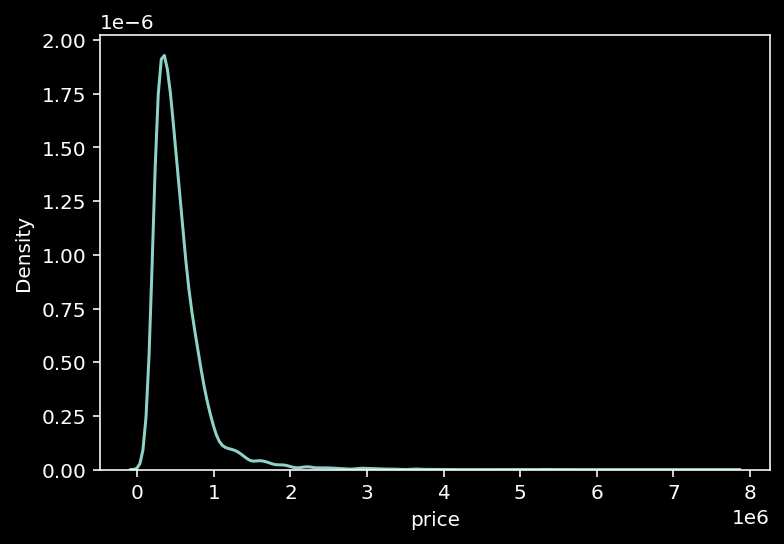

In [18]:
# 분포가 몰려있다.
sns.kdeplot(y)
plt.show()

In [19]:
# 정규분포 형태로 나타날 수 있게 log값으로 변환해준다.
# 에측이 끝난 후에는 np.exp1m() 함수로 되돌려준 다음 확인하면 될 것

# np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.

y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

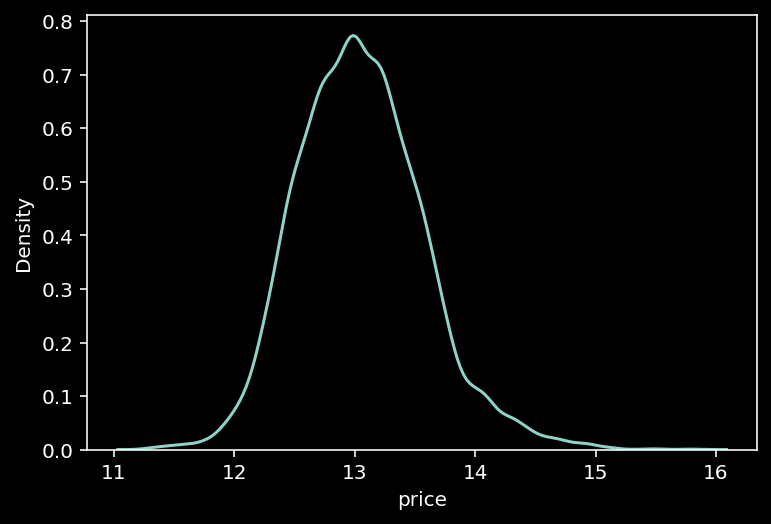

In [20]:
# 분포가 비교적 고르게 나타남.
sns.kdeplot(y)
plt.show()

In [21]:
# info()메소드로 전체 데이터의 자료형을 한 눈에 확인해보자 
# 데이터타입이 정수 또는 실수로 구성되어 있으니, 모델 학습에 있어 지장이 없을 것 같다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2. 모델의 정확도를 향상시켜보자

### 2.1. 반복적으로 수행할 작업을 위한 함수 생성

### RMSE계산

In [22]:
#필요한 라이브러리 가져오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_tes, y_pred는 스케일링 된 y값을 기준으로 되어있으니 데이터를 원본 형태로 되돌린 다음 계산해야 한다.

In [23]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [24]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [25]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [26]:
# 각 모델의 이름 확인
gboost.__class__.__name__
# 풀네임(?)을 알아야 클래스나 함수, 반복문 등에서 자유롭게 사용할 수 있다.

'GradientBoostingRegressor'

In [27]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [28]:
# 위의 과정을 함수로 축약. 블렌딩할 모델리스트, 학습데이터, 타겟데이터를 인자로 받는다.

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

### 2.2. 하이퍼파라미터 튜닝


- 하이퍼파라미터는 모델이 학습하기 전, 임의로 조절해 줄 수 있는 수치를 포함한 변수들(?)이다.
- epoch, batch_size 등이 있음.
- 이 실습에서는 사이킷런의 GridSerchCV 클래스를 활용한다.

In [29]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


### GridSearchCV란?

- 그리드 탐색과 랜덤 탐색
    - 그리드 탐색 : 하이퍼 파라미터의 값을 미리 설정. 그 값들로 조합될 수 있는 모든 경우를 탐색.
    - 랜덤 탐색 : 탐색할 파라미터의 영역만 설정. 최적의 조합을 찾을 수'도' 있으나 과정을 파악할 수 없다. 
    

- GridSearchCV는 당연히 그리드 탐색이다.
- GridSearchCV의 인자들 
    - param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    - scoring : 모델의 성능을 평가할 지표
    - cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    - verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    - n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [30]:
# 최적화 해 볼 하이퍼파라미터와 그리드(값)

param_grid = { 
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

LMS에는 xgboost 관련 하이퍼파라미터 라고 했지만 아래 코드를 보면 딱히 xgboost를 염두에 둔 것 같지는 않다.

다만 n_estimators(약한 학습기 갯수)와 max_depth(학습 분기의 최대 깊이)는<br>
앞서 리스팅한 models의 모델들에서 공통적으로 사용하는 것으로 보인다.

In [31]:
# LGBMRegressor 모델에 대한 튜닝을 진행해보자.
model = LGBMRegressor(random_state=random_state)

In [32]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
# 모델에 대한 그리드 탐색의 (교차검증)결과
grid_model.cv_results_

{'mean_fit_time': array([0.14018769, 0.22638087, 0.47203746, 0.59817328]),
 'std_fit_time': array([0.01141696, 0.07556902, 0.15661518, 0.07956844]),
 'mean_score_time': array([0.00745854, 0.01396375, 0.02442622, 0.03507509]),
 'std_score_time': array([0.00028464, 0.00610469, 0.00844598, 0.01091608]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

위 데이터의 값이 복잡하니 원하는 정보만 열람해보자.
- 우리의 목표는 어떤 파라미터 값에서 높은 점수를 얻는가 이다.
- 우선 파라미터 값의 조합과 테스트 점수라는 두 라벨만 추출해보자

In [34]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [35]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [36]:
#하.. 판다스 배우기 노잼
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


어떻게.. 평가 점수가.. 음수..?!

- 애초에 저 점수는 무엇인가?
: scoring='neg_mean_squared_error'


- 왜 음수로 점수를 내는가?
    - 스코어는 높은 것이 훌륭한 것
    - 이 경우 모델의 파라미터와 테스트 결과값의 거리(차)가 좁을수록 훌륭
    - 작은 숫자가 더 고득점인 것은 참을 수 없으니 음수로 바꿔준다
    - 결과적으로 더 큰 숫자(0에 가까운..)가 고득점이 된다.


- 좀 짜증나지만 이유가 있겠죠... 에..



In [37]:
#양수로 바꾸고 루트 연산을 해주면 짜잔
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [38]:
# 점수가 짜구나.. 
# 이유는 이미 한 번 로그함수로 스케일링한 타겟 데이터를 기준으로 했기 떄문
# 지금 예측값을 보기 보다는 이름을 바꿔두자
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [39]:
# RMSLE점수는 당연히(..) 낮을수록 좋다. 그 순서대로 정렬해보자
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### 위의 과정을 함수로 작성하면..

In [40]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [41]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### 2.3.최적화 된 하이퍼파라미터를 적용

In [42]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

예측 결과 스케일을(드디어) 복구

In [43]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [44]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


앞서 제출한 csv의 데이터프레임에 새롭게 예측한 데이터를 업데이트

In [45]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [46]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.164399.csv


In [47]:
# 제출용 파일을 업로드하는 과정을 함수로 만들어 두기
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [48]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.0168.csv saved!


# 프로젝트 : 캐글 정복
- 전처리, 학습, 예측 과정을 거쳐 제출하기
- 시각화를 포함한 과정 설명
- 회귀모델 예측 정확도 향상(캐글 리더보드 스코어 110000등 이내로 진입)

## 1. 기본준비 및 데이터 전처리

### 경로 재정리

In [49]:
!pwd

/aiffel/aiffel/Exploration/lets_kaggle


In [50]:
path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/'
dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'

### 데이터 가져오기

In [51]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 데이터 확인, 정수형으로 정리

In [52]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [53]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 타겟 컬럼 분리, id컬럼 삭제

In [54]:
y = train['price']
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 테스트 데이터도 정리해주자

In [55]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 타겟데이터 y 스케일링

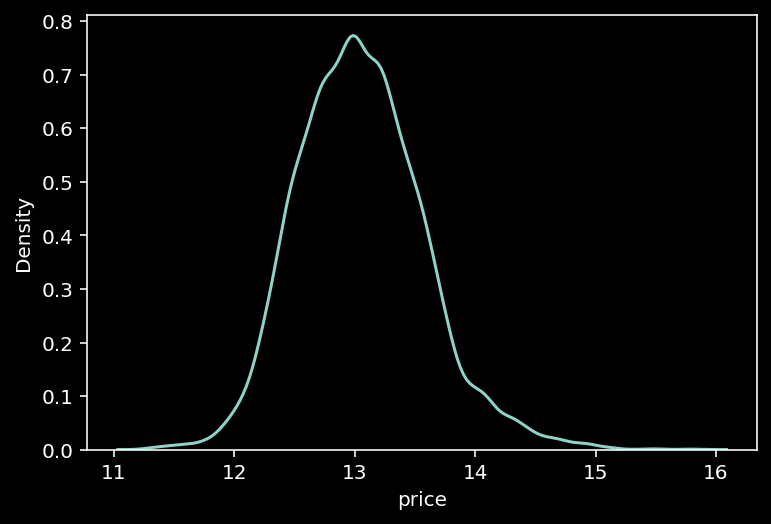

In [56]:
# 로그변환
y = np.log1p(y)
# 분포를 시각적으로 확인
sns.kdeplot(y)
plt.show()

## 2. 모델 튜닝

In [57]:
#모델들

random_state=2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### 2.1. 모델 튜닝을 위해 앞서 정의한 함수들을 정리해보자

#### 인자로 받을 값들에 로그함수가 적용되어 있으므로 지수함수를 적용해준다.
> ```def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))```

#### 앙상블 할 모델들에 대한 개별 RMSE 점수를 딕셔너리로 저장하는 함수

인자 설명
- models : 앙상블 할 모델들의 리스트
- train : 학습 데이터
- y : 타겟 데이터

>```def get_scores(models, train, y): 
        빈 딕셔너리 생성
        df = {} 
        앙상블할 모델 리스트를 대상으로 반복문 작성
        for model in models:
            model_name = model.__class__.__name__
        데이터 스플릿
            X_train, X_test, y_train, y_test = train_test_split(
            train, y, random_state=random_state, test_size=0.2)        
            model.fit(X_train, y_train)
        타겟 예측
            y_pred = model.predict(X_test)
        모델명을 키, 앞서 정의한 rmse값을 밸류로 받음
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        데이터프레임 형태로 시각화 한 것을 리턴으로 받음
        return score_df```

#### 그리드 서치
인자 설명
- model : 그리드서치로 튜닝할 모델명
- train, y : 학습, 타겟 데이터
- param_grid : 튜닝할 하이퍼파라미터의 종류(딕셔너리 형태)
- verbose : 
    - 0 : 아무 것도 출력하지 않습니다.
    - 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줍니다.
    - 2 : 미니 배치마다 손실 정보를 출력합니다.
- n_jobs : 그리드탐색에 사용할 CPU수


>```def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    GridSearchCV 모델로 초기화
        - 점수는 n_mse로 측정
        - cv : 교차검증을 위한 학습데이터 분할 수
        grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                                  cv=5, verbose=verbose, n_jobs=n_jobs)
    모델 fitting
        grid_model.fit(train, y)
    결과값 저장
        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
    데이터 프레임 생성
        results = pd.DataFrame(params)
        results['score'] = score
    RMSLE 값 계산 후 정렬
        results['RMSLE'] = np.sqrt(-1 * results['score'])
        results = results.sort_values('RMSLE')
    return results```

#### 제출용 파일 업로드를 위한 함수

>```def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))```

### 2.2. 모델들의 RMSE를 확인해보자.

In [58]:
get_scores(models, train, y)

,RMSE
RandomForestRegressor,135139.591426
GradientBoostingRegressor,130361.233685
XGBRegressor,127865.518649
LGBMRegressor,120099.067237


### 2.3. 점수가 높은 LGBM부터 진행해보자

#### 몇 번의 그리드 탐색을 진행해 보았다.
- 부스팅 타입의 랜덤포레스트는 수치를 확인할 수 없었다.
- 반복 횟수는 500이하 1000이상에서 점수가 좋지 않았다.
- depth는 5~ 30 사이를 확인해 본 결과 10이 가장 적정 수치로 보였다.
- 이외에도 많은 하이퍼파라미터 인자가 있었으나 시간에 비해 유효성이 낮았다.

In [71]:
param_grid = {
    'n_estimators': [500, 650, 800],
    'max_depth': [1, 5, 10],
    'learning_rate' : [0.05, 0.1]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.05,10,650,-0.025880,0.160873
8,0.05,10,800,-0.025904,0.160946
6,0.05,10,500,-0.025927,0.161020
15,0.10,10,500,-0.026245,0.162004
5,0.05,5,800,-0.026276,0.162097
4,0.05,5,650,-0.026368,0.162382
16,0.10,10,650,-0.026376,0.162406
12,0.10,5,500,-0.026456,0.162653
13,0.10,5,650,-0.026510,0.162818
17,0.10,10,800,-0.026552,0.162947


In [91]:
# 점수가 가장 좋은 파라미터로 학습/예측
model = LGBMRegressor(max_depth=10, n_estimators=650, learning_rate=0.5, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)


In [92]:
# 스케일링 복구
prediction = np.expm1(prediction)

In [93]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [94]:
#새로 학습한 예측값을 적용
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.474336e+05
1,15036,5.460958e+05
2,15037,1.252149e+06
3,15038,2.996389e+05
4,15039,2.790290e+05


In [95]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, 'lgbm', '0.160873')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.160873.csv


In [98]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    dir_path = '/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data/'
    submission_path = join(dir_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(dir_path, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [99]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.01608')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_lgbm_RMSLE_0.01608.csv saved!


#### 점수는 한참 부족했다(..)

### 2.4. XGB 모델을 이용해보자.

In [70]:
train_data_path = join(dir_path, 'train.csv')
test_data_path = join(dir_path, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# date를 정수형 데이터로 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# 타겟 데이터 price 분리
y = train['price']
del train['price']

# id 컬럼 제거
del train['id']

# 테스트 데이터 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
y = np.log1p(y)

In [69]:
# XGB회귀 모델에 대한 그리드 탐색
# 계속 아래와 같은 경고가 발생하고 결과가 나오지 않았다.
# 덕분에 여러 하이퍼파라미터에 대해서 엄청나게 검색했다.
# 결과적으로 한 번도 결과를 확인하지 못해 이전 우수노드를 확인해보았더니 한 번 실행에 시간이 엄청 걸렸다는 회고를 확인했다.
# 하이퍼파라미터를 수동으로 조절해가며 결과값을 확인해보기로 결정.
param_grid = {
   'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

KeyboardInterrupt: 

In [105]:
model = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1500,
    max_depth= 5,
    min_child_weight = 1,
    eval_metric = 'rmse',
    scale_pos_weight = 1,
    objective =  'reg:squarederror',
    random_state = random_state
)
model.fit(train, y)
prediction = model.predict(test)

In [106]:
prediction = np.expm1(prediction)

In [107]:
submission_path = join(dir_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [108]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.303379e+05
1,15036,4.650724e+05
2,15037,1.446864e+06
3,15038,3.061110e+05
4,15039,3.283259e+05


In [109]:
save_submission(model, train, y, test, 'XGB', rmsle='0.163')

/aiffel/aiffel/Exploration/lets_kaggle/kaggle_kakr_housing/data//submission_XGB_RMSLE_0.163.csv saved!


#### XGB모델 튜닝
- 그리드서치 과정에서 교차검증 변인들을 최소로 줄여도 너무 너무 너무..느렸다.
- 구글링을 통해 XGB모델의 하이퍼파라미터들을 학습했다.
- 하이퍼파라미터의 종류도 엄청 많고, 버전에 따라 변화가 많음.
- 그 와중에, 아래 블로그에 가장 쉽게 정리가 되어있었다.
> https://riverzayden.tistory.com/17


## 3. 목표 스코어 달성

### XGBRegression으로 목표 스코어를 달성했다.
![](./109526.jpg)

### 위 제출에 사용한 모델과 하이퍼파라미터 코드
>```model = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1500,
    max_depth= 5,
    min_child_weight = 1,
    eval_metric = 'rmse',
    scale_pos_weight = 1,
    objective =  'reg:squarederror',
    random_state = random_state
)```

In [110]:
# 해당하는 하이퍼파라미터 수치로 RMSLE를 확인해보았다. 
param_grid = {
   'learning_rate': [0.1],
    'n_estimators': [1500],
    'max_depth': [5]
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,5,1500,-0.02668,0.16334


## 4. 마치며

### 기억에 남는 학습 내용



- 앙상블(블렌딩) 기법들에 대한 이론적 내용.


- 특히 bagging 방식이 랜덤포레스트 모델 그 자체와 비슷하게 느껴진 부분이 흥미로웠다.


- 그리드서치와 하이퍼파라미터 튜닝


### 어려웠던 점


- XGBoost에 대한 그리드서치가 잘 작동하지 않았던 점 (원래 엄청 느리다는 내용을 많이 찾아보게 되긴 했지만)


- 시각화를 위한 pandas 사용이 너무 귀찮게 느껴졌다. 
> 흥미롭게 느껴지는 프로젝트에 참가한다면 전처리 과정에서 적극적으로 이용할 것 같지만 학습을 위한 실습 단계에서는 많이 의미가 퇴색되는 느낌이 들어 그런 것 같다.


### 추가로 해보고 싶은 점
- 기반 지식이 프로젝트 진행에 큰 차질을 주지 않을 정도가 되면 처음부터 해보고 싶다.

    : 데이터 분석과 전처리, 모델 선정, 최적화 등등..

### 총평
> 그리드 탐색이나 임베딩 등을 포함해, 학습 시간 자체가 긴 경우가 많아지고 있다.
>
>이론에 대한 학습은 과정에서 2중 3중으로 진행되고 있으니 앞으로의 익스플로레이션 진행은 주어진 목표를 성취하는 것에 더 집중해서 진행하는 것이 좋을 것 같다.